# 0.0 Imports

In [163]:
import math
import numpy as np
import pandas as pd
import random
import json
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime as dt
import requests
import scikitplot as skplt


from scipy import stats
from scipy.stats import chi2_contingency
#from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors  as nh



warnings.filterwarnings( 'ignore' )


### 0.1. Helper functions

In [2]:
def cramer_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))



# 0.2 Load Data

In [81]:
df_raw = pd.read_csv('C:/Users/Pamela.magalhaes/Documents/Estudos/pa004/train.csv', low_memory=False)

In [4]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. DESCRICAO DOS DADOS

In [82]:
df_raw.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [6]:
df_raw.sample()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
25242,25243,Female,45,1,16.0,1,1-2 Year,No,31048.0,152.0,108,0


In [83]:
df1 = df_raw.copy()

In [84]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

# Rename
df1.columns = cols_new

In [85]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.1. Data Dimensions

In [11]:
df1.shape

(381109, 12)

## 1.2. Data types

In [12]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA's

In [13]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Descriptive Statistical

In [86]:
num_attributes = df1.select_dtypes (include = ['int64','int32'])
cat_attributes = df1.select_dtypes (exclude = ['int64','int32'])

In [23]:
#Verificando
num_attributes.sample(2)

,id,age,driving_license,previously_insured,vehicle_age,vintage,response
364474,364475,41,1,1,1,95,0
48200,48201,57,1,1,1,130,0


In [24]:
#Verificando
cat_attributes.sample(2)

,gender,region_code,vehicle_damage,annual_premium,policy_sales_channel
227678,Female,39.0,No,30582.0,160.0
21924,Female,28.0,Yes,38937.0,25.0


### 1.4.1 Numerical Attributes

In [87]:
#Central Tendency - Mean and Median
ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew and kurtosis
d1 = pd.DataFrame (num_attributes.apply(np.std)).T
d2 = pd.DataFrame (num_attributes.apply(min)).T
d3 = pd.DataFrame (num_attributes.apply(max)).T
d4 = pd.DataFrame (num_attributes.apply (lambda x: x.max() - x.min())).T
d5 = pd.DataFrame (num_attributes.apply (lambda x: x.skew () )).T
d6 = pd.DataFrame (num_attributes.apply (lambda x: x.kurtosis () )).T

#Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
4,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
5,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.4.2 Categorical Attributes

In [25]:
cat_attributes.apply (lambda x: x.unique().shape[0])

gender                      2
region_code                53
vehicle_damage              2
annual_premium          48838
policy_sales_channel      155
dtype: int64

# 2.0. FEATURE ENGENEERING

In [88]:
df2 = df1.copy ()

In [89]:
#vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply (lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year'
                                                                        if x == '1-2 Year'  else 'below_1_year')
#vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply (lambda x: 1 if x == 'Yes' else 0)

## 2.1 Mapa mental de hipóteses

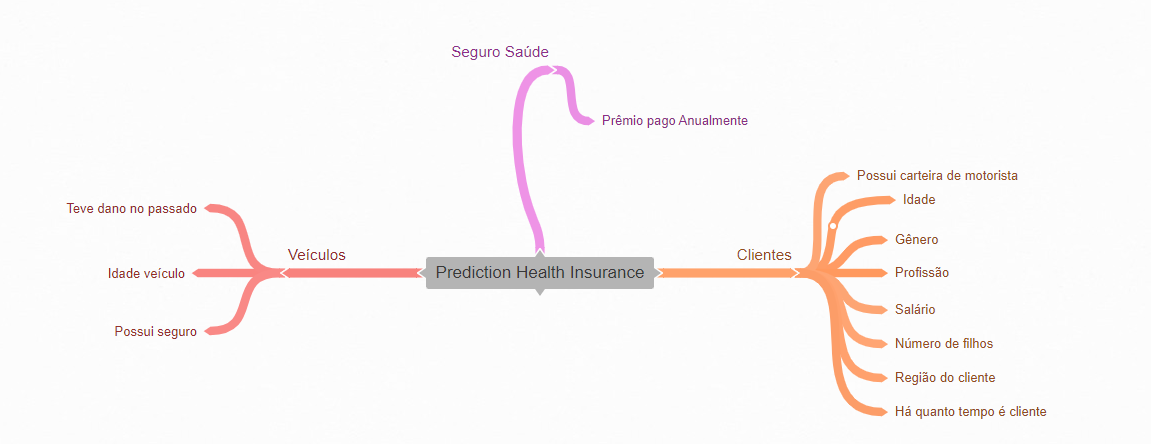

In [90]:
Image ('C:/Users/Pamela.magalhaes/Documents/Estudos/pa004/mapa_hipoteses_pa004.png')

## 2.2 Criação das hipóteses

#### 2.2.1 Hipóteses Clientes

**1.** Clientes com carteira de motorista deveriam aderir mais ao seguro de carro.

**2.** Clientes com mais idade deveriam aderir mais ao seguro de carro.

**3.** Clientes do gênero feminino deveriam aderir mais ao seguro de carro.

**4.** Clientes com salário maior deveriam aderir mais ao seguro de carro.

**5.** Clientes com menos filhos deveriam aderir mais ao seguro de carro.

**6.** Clientes que são clientes há mais tempo deveriam aderir mais ao seguro de carro.

#### 2.2.2 Hipóteses Veículos

**1.** Clientes que possuem carro que teve dano no passado deveriam aderir mais ao seguro de carro.

**2.** Clientes que possuem carros mais novos deveriam aderir mais ao seguro de carro.

**3.** Clientes que já possuem seguro de automóvel deveriam aderir renovar o seguro.

#### 2.2.3 Seguro Saúde

**1.** Clientes que pagam prêmios maiores deveriam aderir mais ao seguro de carro.

### 2.3 Lista Final das hipóteses (Hipóteses que temos dados para comprovar)

**1.** Clientes com carteira de motorista deveriam aderir mais ao seguro de carro.

**2.** Clientes com mais idade deveriam aderir mais ao seguro de carro.

**3.** Clientes do gênero feminino deveriam aderir mais ao seguro de carro.

**4.** Clientes que são clientes há mais tempo deveriam aderir mais ao seguro de carro.

**5.** Clientes que possuem carro que teve dano no passado deveriam aderir mais ao seguro de carro.

**6.** Clientes que possuem carros mais novos deveriam aderir mais ao seguro de carro.

**7.** Clientes que já possuem seguro de automóvel deveriam aderir renovar o seguro.

**8.** Clientes que pagam prêmios maiores deveriam aderir mais ao seguro de carro.

# 3.0. DATA FILTERING

In [90]:
df3 = df2.copy()

In [91]:
df3.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0


# 4.0. EDA - ANALISE EXPLORATORIA DOS DADOS

In [92]:
df4 = df3.copy()

## 4.1 Univariate Analysis

In [93]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

<Axes: xlabel='response', ylabel='age'>

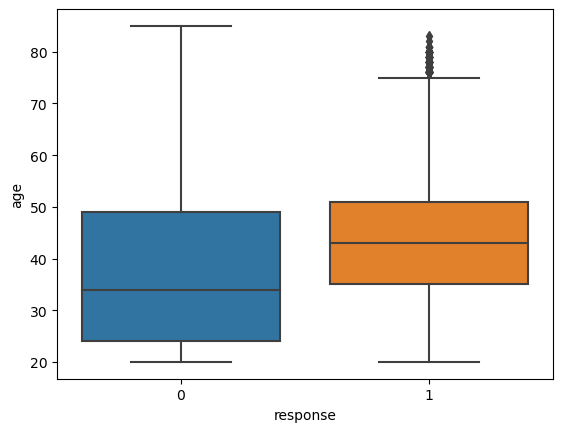

In [36]:
#age
sns.boxplot(x ='response', y = 'age', data=df4)

<Axes: xlabel='age', ylabel='Count'>

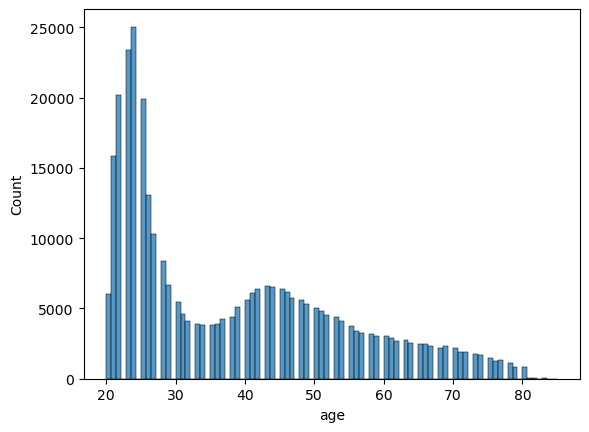

In [37]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux00)

<Axes: xlabel='age', ylabel='Count'>

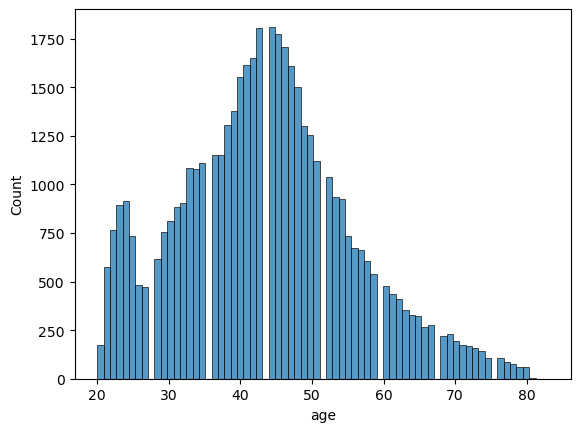

In [38]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux00)

<Axes: xlabel='response', ylabel='annual_premium'>

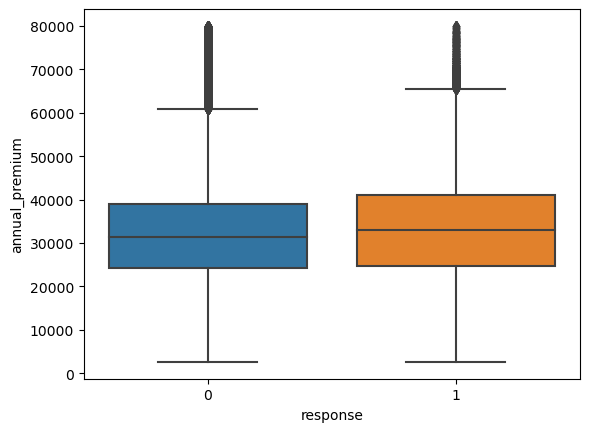

In [45]:
#annual_premium
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x ='response', y = 'annual_premium', data=aux)

#Foi necessário filtrar pois há muitos outliers

<Axes: xlabel='annual_premium', ylabel='Count'>

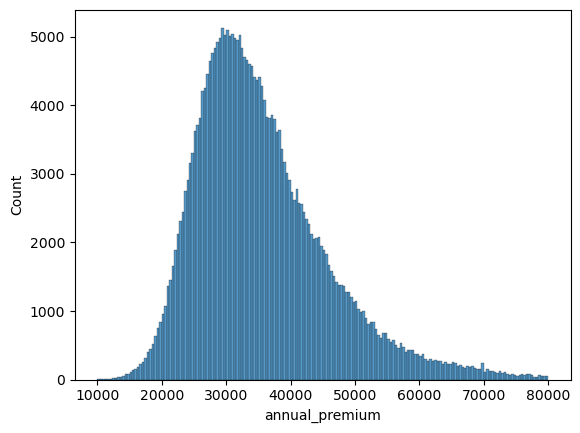

In [48]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux00)

<Axes: xlabel='annual_premium', ylabel='Count'>

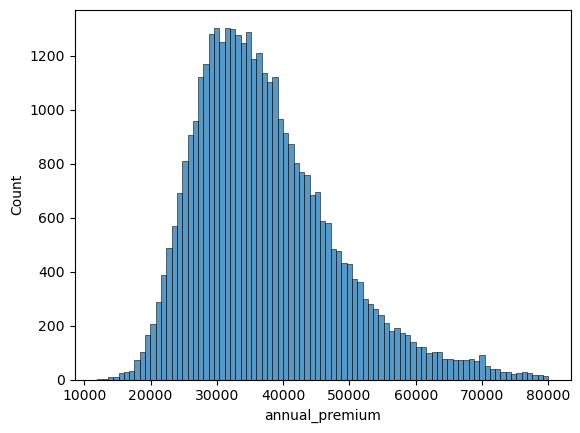

In [49]:
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux00)

In [51]:
#driving_license
aux = df4[['driving_license', 'response']].groupby ('response').sum().reset_index()
aux.head()
aux['driving_license_percent'] = aux['driving_license'] / aux['driving_license'].sum()
aux

,response,driving_license,driving_license_percent
0,0,333628,0.877283
1,1,46669,0.122717


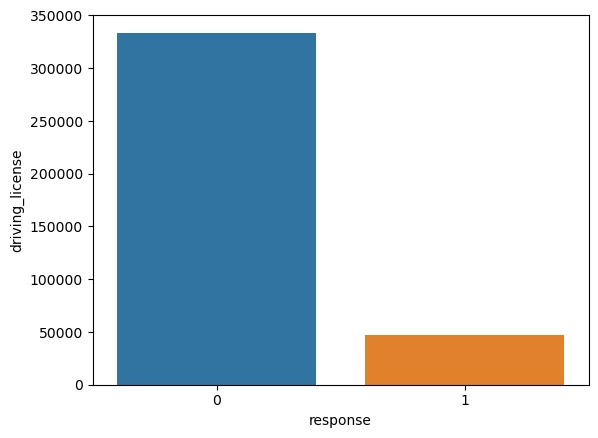

In [166]:
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux );

<Axes: xlabel='region_code', ylabel='id'>

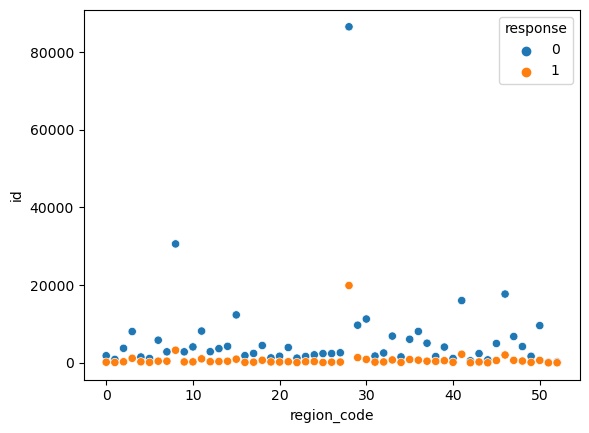

In [54]:
#region_code
aux0 = df4 [['id', 'region_code', 'response' ]].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y= 'id', hue = 'response', data=aux0)

In [56]:
#previously_insured
pd.crosstab( df4['previously_insured'], df4 ['response']).apply(lambda x : x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [70]:
# Exemplo de dados de exemplo
vehicle_age = ['below_1_year', 'below_1_year', 'over_2_years', 'between_1_2_year', 'below_1_year']
response = [0, 1, 0, 1, 1]

# Contagem total de registros para response = 0
total_0 = response.count(0)
# Contagem total de registros para response = 1
total_1 = response.count(1)

# Contagem de registros para cada opção e valor de response
below_1_year_count_0 = sum([1 for age, resp in zip(vehicle_age, response) if age == 'below_1_year' and resp == 0])
over_2_years_count_0 = sum([1 for age, resp in zip(vehicle_age, response) if age == 'over_2_years' and resp == 0])
between_1_2_year_count_0 = sum([1 for age, resp in zip(vehicle_age, response) if age == 'between_1_2_year' and resp == 0])

below_1_year_count_1 = sum([1 for age, resp in zip(vehicle_age, response) if age == 'below_1_year' and resp == 1])
over_2_years_count_1 = sum([1 for age, resp in zip(vehicle_age, response) if age == 'over_2_years' and resp == 1])
between_1_2_year_count_1 = sum([1 for age, resp in zip(vehicle_age, response) if age == 'between_1_2_year' and resp == 1])

# Cálculo das porcentagens para response = 0
below_1_year_percentage_0 = (below_1_year_count_0 / total_0) * 100
over_2_years_percentage_0 = (over_2_years_count_0 / total_0) * 100
between_1_2_year_percentage_0 = (between_1_2_year_count_0 / total_0) * 100

# Cálculo das porcentagens para response = 1
below_1_year_percentage_1 = (below_1_year_count_1 / total_1) * 100
over_2_years_percentage_1 = (over_2_years_count_1 / total_1) * 100
between_1_2_year_percentage_1 = (between_1_2_year_count_1 / total_1) * 100

# Exibição dos resultados
print("Para response = 0:")
print("Porcentagem de below_1_year:", below_1_year_percentage_0, "%")
print("Porcentagem de over_2_years:", over_2_years_percentage_0, "%")
print("Porcentagem de between_1_2_year:", between_1_2_year_percentage_0, "%")

print("\nPara response = 1:")
print("Porcentagem de below_1_year:", below_1_year_percentage_1, "%")
print("Porcentagem de over_2_years:", over_2_years_percentage_1, "%")
print("Porcentagem de between_1_2_year:", between_1_2_year_percentage_1, "%")


Para response = 0:
Porcentagem de below_1_year: 50.0 %
Porcentagem de over_2_years: 50.0 %
Porcentagem de between_1_2_year: 0.0 %

Para response = 1:
Porcentagem de below_1_year: 66.66666666666666 %
Porcentagem de over_2_years: 0.0 %
Porcentagem de between_1_2_year: 33.33333333333333 %


<Axes: xlabel='response', ylabel='policy_sales_channel'>

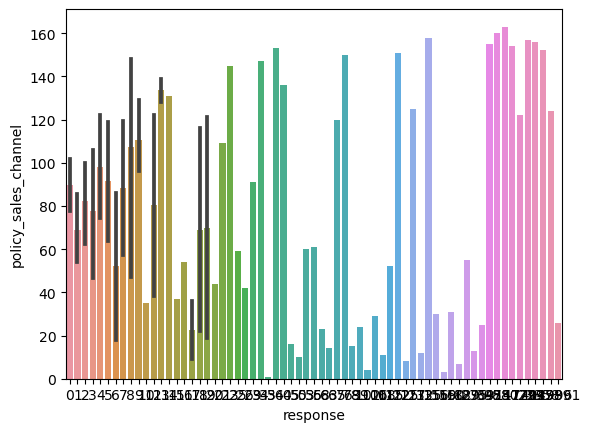

In [74]:
#policy_sales_channel
#plt.figure(figsize(24,12))
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux)

In [ ]:
#gender

In [ ]:
#vehicle_damage

<Axes: xlabel='response', ylabel='vintage'>

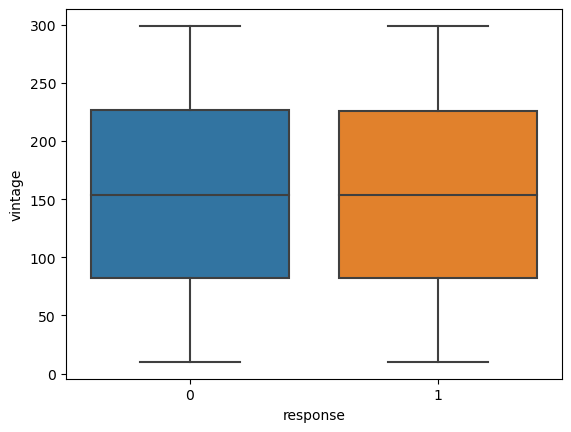

In [76]:
#vintage
sns.boxplot(x ='response', y = 'vintage', data=df4)

<Axes: xlabel='vintage', ylabel='Count'>

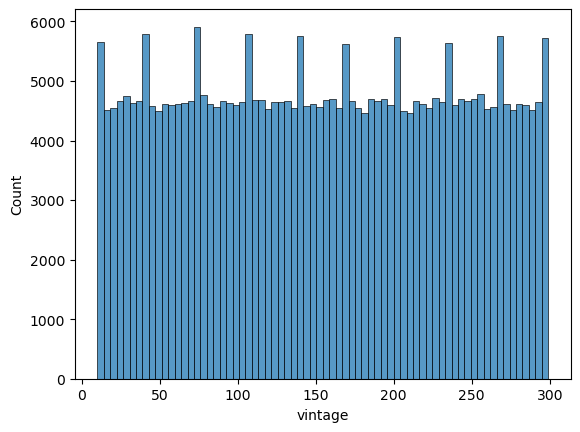

In [78]:
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux00)

<Axes: xlabel='vintage', ylabel='Count'>

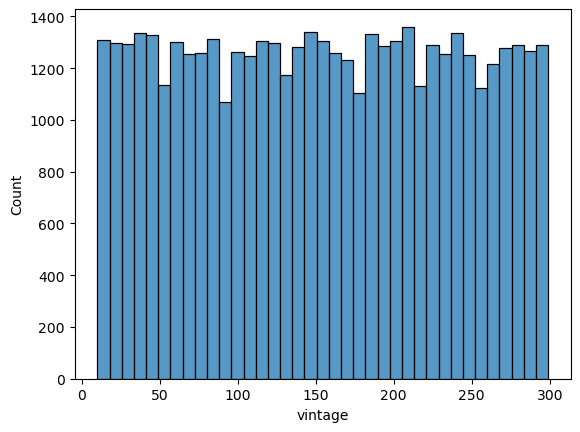

In [79]:
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux00)

## 4.2 Analise Bivariada

### H1 - Clientes com carteira de motorista deveriam aderir mais ao seguro de carro.
**False** Clientes com carteira de motorista não necessariamente se interessam por aderir seguro de carro.

### H2 - Clientes com mais idade deveriam aderir mais ao seguro de carro.
**False** Clientes com mais idade não aderem mais ao seguro de carro, quanto os jovens aderem.

### H3 - Clientes do gênero feminino deveriam aderir mais ao seguro de carro.
**True** 

### H4 - 4. Clientes que são clientes há mais tempo deveriam aderir mais ao seguro de carro.
**True** 

### H5 - Clientes que possuem carro que teve dano no passado deveriam aderir mais ao seguro de carro.
**False** O fato do cliente ter veículo que sofreu dano no passado não influência no interesse em aderir seguro de carro.

### H6 - Clientes que possuem carros mais novos deveriam aderir mais ao seguro de carro.
**False** Clientes com carros semi novos (mais de um ano) tem um interesse maior em aderir ao seguro de carro.

### H7 - Clientes que já possuem seguro de automóvel deveriam aderir renovar o seguro.
**False** A maioria não tem interesse em continuar com o seguro no futuro.

### H8 - Clientes que pagam prêmios maiores deveriam aderir mais ao seguro de carro.
**True**

### 4.2.1 Resumo das Hipoteses

In [315]:
from tabulate import tabulate

In [316]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1','Falsa','Baixa'],
      ['H2','Falsa','Alta'],
      ['H3','Verdadeira','Alta'],
      ['H4','Verdadeira','Alta'],
      ['H5','Falsa','Media'],
      ['H6','Falsa','Media'],
      ['H7','Falsa','Baixa'],
      ['H8','Verdadeira','Alta'], 
      ]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Alta
H3           Verdadeira   Alta
H4           Verdadeira   Alta
H5           Falsa        Media
H6           Falsa        Media
H7           Falsa        Baixa
H8           Verdadeira   Alta


# 5.0. DATA PREPARATION

In [143]:
df5 = df4.copy()

In [144]:
df5.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [145]:
x = df4.drop ('response', axis=1)
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(x,y, test_size=0.20)
df5 = pd.concat ([x_train, y_train], axis=1)

## 5.1. Standardization

In [146]:
ss = pp.StandardScaler()
#annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 5.2. Rescaling

In [147]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

#age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

#vintage
df5['vintage'] = mms_age.fit_transform(df5[['vintage']].values)

## 5.3. Enconder

In [148]:
#gender
target_enconde_gender =df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_enconde_gender)

#region_code - Frequency encoding / Target encoding / Weighted target Encoding
target_enconde_region_code =df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_enconde_region_code)

#vehicle_age - One hot enconding / Frequency encoding / Order Encoding
df= pd.get_dummies(df5, prefix= 'vehicle_age', columns = ['vehicle_age'])

#policy_sales_channel Frequency encoding / Target encoding
fe_policy_sales_channel =df5.groupby('policy_sales_channel').size() / len (df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

In [149]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
5174,5175,0.139064,0.046154,1,0.076574,1,below_1_year,0,-0.220836,0.353534,0.972318,0
341181,341182,0.103775,0.076923,1,0.188209,1,below_1_year,0,-0.156537,0.353534,0.114187,0
132457,132458,0.139064,0.307692,1,0.188209,1,between_1_2_year,0,-0.113593,0.194219,0.525952,0
65650,65651,0.139064,0.015385,1,0.073564,0,between_1_2_year,1,-1.625879,0.028076,0.346021,0
266408,266409,0.139064,0.323077,1,0.088949,1,between_1_2_year,0,0.411916,0.209153,0.608997,0


## 5.4. Validation preparation

In [150]:
#gender
x_val.loc[:, 'gender'] = x_val.loc[:,'gender'].map(target_enconde_gender)

#age
x_val.loc[:, 'age'] = mms_age.transform(x_val[['age']].values)

#region_code
x_val.loc[:, 'region_code'] = x_val.loc[:,'region_code'].map(target_enconde_region_code)

#vehicle_age
x_val= pd.get_dummies(x_val, prefix= 'vehicle_age', columns = ['vehicle_age'])

#annual_premium
x_val.loc[:, 'annual_premium'] = ss.transform(x_val[['annual_premium']].values)

#policy_sales_channel
x_val.loc[:, 'policy_sales_channel'] = x_val['policy_sales_channel'].map(fe_policy_sales_channel)

#vintage
x_val.loc[:, 'vintage'] = mms_age.transform(x_val[['vintage']].values)

#fillna
x_val = x_val.fillna(0)
                                        


# 6.0. FEATURE SELECTION

In [151]:
df6 = df5.copy()

## 6.1. Features Importance

In [155]:
# Carregue os dados e realize a codificação one-hot das variáveis categóricas
df_encoded = pd.get_dummies(df5, columns=['vehicle_age'])

# Separe os recursos (features) e os rótulos de classe
x_train_n = df_encoded.drop(['id', 'response'], axis=1)
y_train_n = df_encoded['response']

# Defina e treine o modelo
forest = ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.273253
0                annual_premium    0.244935
0                           age    0.164213
0                   region_code    0.105297
0                vehicle_damage    0.068908
0          policy_sales_channel    0.059911
0            previously_insured    0.055919
0      vehicle_age_below_1_year    0.013875
0  vehicle_age_between_1_2_year    0.006068
0                        gender    0.004811
0      vehicle_age_over_2_years    0.002305
0               driving_license    0.000504


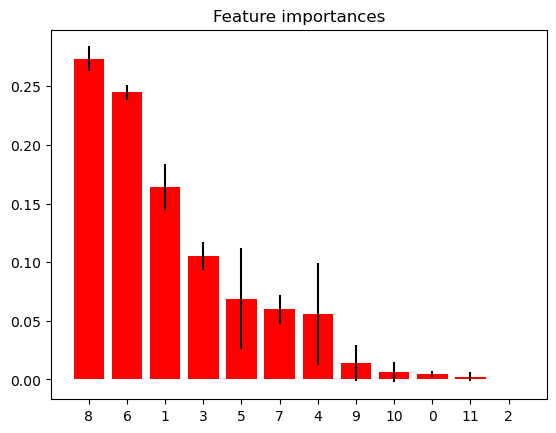

In [156]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning Modelling# 

In [157]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

In [159]:
x_train = df6[ cols_selected ]
x_val = x_val[ cols_selected ]


## 7.1. KNN Classifier

In [161]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

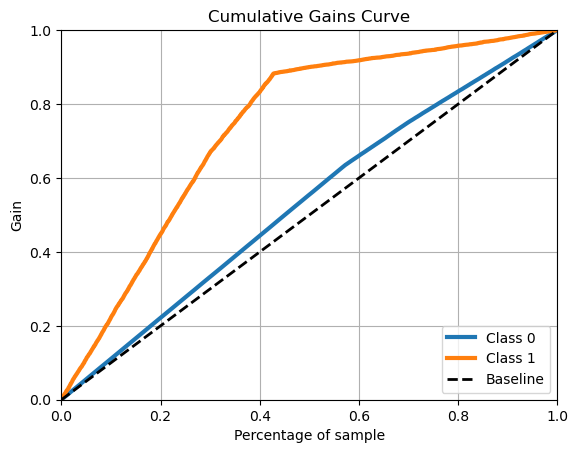

In [164]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

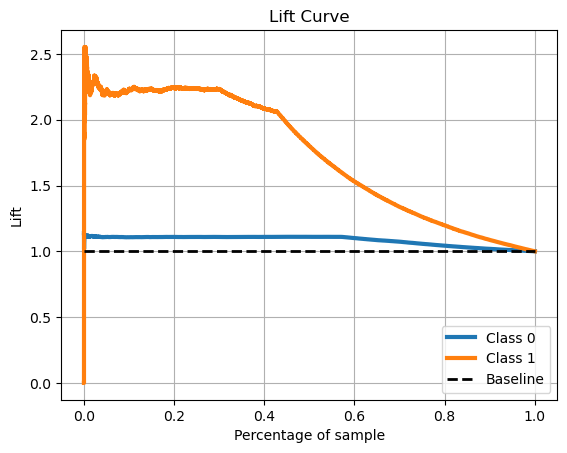

In [165]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_knn );